In [30]:
#!pip install evidently
#!pip install jupyter_contrib_nbextensions
#!jupyter nbextension install --sys-prefix --symlink --overwrite --py evidently
#!jupyter nbextension enable evidently --py --sys-prefix
#!pip install alibi
#!pip install alibi-detect

****Load Dataset****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\supriyoroy.banerjee\Downloads\drift_predictive_maintenance\predictive_maintenance.csv")
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(" ","_") for x in df.columns]

id_var = df.iloc[:,[0,1]]
num_var = df.iloc[:,[3,4,5,6,7]]
cat_var = df.iloc[:,[2,8,9]]

print(f"""Variable type distribution:
identifying variables:{id_var.shape[1]} ({", ".join(id_var.columns)})
categorical variables:{cat_var.shape[1]} ({", ".join(cat_var.columns)})
    numeric variables:{num_var.shape[1]} ({", ".join(num_var.columns)})""")

Variable type distribution:
identifying variables:2 (udi, product_id)
categorical variables:3 (type, target, failure_type)
    numeric variables:5 (air_temperature_[k], process_temperature_[k], rotational_speed_[rpm], torque_[nm], tool_wear_[min])


In [2]:
print(f'''Target distribution:
no failures: {df['target'].value_counts()[0]}
   failures:  {df['target'].value_counts()[1]}''')

Target distribution:
no failures: 9661
   failures:  339


In [3]:
df[df['target'] == 0]['failure_type'].value_counts()

No Failure         9643
Random Failures      18
Name: failure_type, dtype: int64

**Preprocessing step - Lable encoding**

In [4]:
#from sklearn import preprocessing
#label_encoder = preprocessing.LabelEncoder()
enc_dict = {'L':0,
            'M':1,
            'H':2}
# Create the mapped values in a new column
df['type'] = df['type'].map(enc_dict)

**Split data into training and test datasets**

In [5]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['failure_type', 'target', 'udi', 'product_id'])
y = df['failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2022)

print(f'''Shape of train and test data:
training data:{X_train.shape[0]} obs
testing data :{X_test.shape[0]} obs''')

Shape of train and test data:
training data:7000 obs
testing data :3000 obs


**Model drift data preparation**

In [6]:
X_drift = X_test.copy()
y_drift = y_test.copy()

# drift in numeric variable - rotational speed
import random
arr = np.array(X_drift['rotational_speed_[rpm]'])
for i in range(len(X_drift)):
    arr[i] = random.randint(1600, 2900)
X_drift['rotational_speed_[rpm]'] = arr

# drift in categorical variable - type
X_drift = X_drift.sort_values(by = 'type', ascending = True)

X_drift['type'].iloc[0:1000] = [2 for i in (X_drift['type'].iloc[0:1000]) ]
X_drift['type'].iloc[1000:2000] = [0 for i in (X_drift['type'].iloc[1000:2000]) ]
X_drift['type'].iloc[2000:3000] = [1 for i in (X_drift['type'].iloc[2000:3000]) ]

print(f'''Shape of drift data:
drift data:{X_drift.shape[0]} obs''')

Shape of drift data:
drift data:3000 obs


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   udi                      10000 non-null  int64  
 1   product_id               10000 non-null  object 
 2   type                     10000 non-null  int64  
 3   air_temperature_[k]      10000 non-null  float64
 4   process_temperature_[k]  10000 non-null  float64
 5   rotational_speed_[rpm]   10000 non-null  int64  
 6   torque_[nm]              10000 non-null  float64
 7   tool_wear_[min]          10000 non-null  int64  
 8   target                   10000 non-null  int64  
 9   failure_type             10000 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


In [8]:
df.describe()

,udi,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,0.500300,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,0.671301,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


*a) drift in numeric variable - rotational speed*

In [9]:
print(f"""Rotation speed distribution in historical dataset:
      avg: {df['rotational_speed_[rpm]'].describe()[1]}
      min: {df['rotational_speed_[rpm]'].describe()[3]}
   median: {df['rotational_speed_[rpm]'].describe()[5]}
      max: {df['rotational_speed_[rpm]'].describe()[-1]}\n""")

print(f"""Rotation speed distribution in drift dataset:
      avg: {X_drift['rotational_speed_[rpm]'].describe()[1]}
      min: {X_drift['rotational_speed_[rpm]'].describe()[3]}
   median: {X_drift['rotational_speed_[rpm]'].describe()[5]}
      max: {X_drift['rotational_speed_[rpm]'].describe()[-1]}""")

Rotation speed distribution in historical dataset:
      avg: 1538.7761
      min: 1168.0
   median: 1503.0
      max: 2886.0

Rotation speed distribution in drift dataset:
      avg: 2244.289333333333
      min: 1600.0
   median: 2238.0
      max: 2900.0


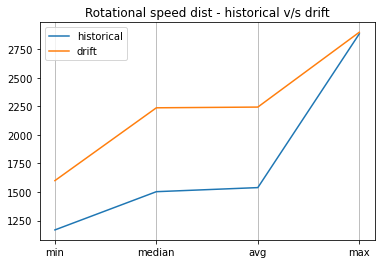

In [10]:
hist_avg = df['rotational_speed_[rpm]'].describe()[1]
hist_min = df['rotational_speed_[rpm]'].describe()[3]
hist_median = df['rotational_speed_[rpm]'].describe()[5]
hist_max = df['rotational_speed_[rpm]'].describe()[-1]
hist_rotational_speed = [hist_min, hist_median, hist_avg, hist_max ]

drift_avg = X_drift['rotational_speed_[rpm]'].describe()[1]
drift_min = X_drift['rotational_speed_[rpm]'].describe()[3]
drift_median = X_drift['rotational_speed_[rpm]'].describe()[5]
drift_max = X_drift['rotational_speed_[rpm]'].describe()[-1]
drift_rotational_speed = [drift_min, drift_median, drift_avg, drift_max ]

labels = ['min', ' median', 'avg', 'max']
plt.plot(hist_rotational_speed, label ='historical')
plt.plot(drift_rotational_speed, label = 'drift')
plt.xticks([0.0, 1.0, 2.0, 3.0], ['min', 'median', 'avg', 'max'])
plt.grid(axis = 'x')
plt.legend()
plt.title('Rotational speed dist - historical v/s drift')
plt.show()

*b) drift in categorical variable - type*

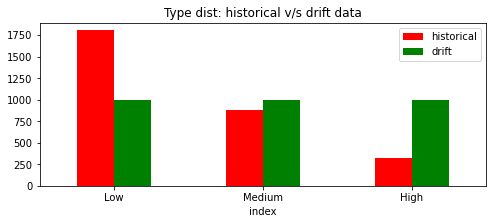

In [11]:
hist_type = X_test['type'].value_counts().reset_index().rename(columns = {'type' : 'historical'})

drift_type = X_drift['type'].value_counts().reset_index().rename(columns = {'type' : 'drift'})

hist_type = hist_type.merge(drift_type, how = 'inner', on = ['index'])

plt.rcParams['figure.figsize'] = (8,3)
hist_type.plot(x='index',
        kind='bar',
        stacked=False, color={"historical": "red", "drift": "green"},
        title='Type dist: historical v/s drift data')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'], rotation = 0)
plt.show()

*c) drift in target variable*

In [12]:
X_train['target'] = df['failure_type']
X_test['target'] = df['failure_type']
X_drift['target'] = df['failure_type']

In [13]:
X_drift1 = X_drift.copy()
X_drift1['target'] = np.where(X_drift1['target'] == 'Random Failures', 'Overstrain Failure', X_drift1['target'])

d1 = X_drift1['target'].value_counts().reset_index().rename(columns = {'target':'drift'})

d = X_drift['target'].value_counts().reset_index()
d = d.merge(d1, how = 'left', on = 'index')
d = d.fillna(0)
d.drift = d.drift.astype('int')


In [14]:
drift = pd.concat([X_drift.loc[:,['target']].rename(columns = {'target':'historical'}), 
                   X_drift1.loc[:,['target']]], axis =1)

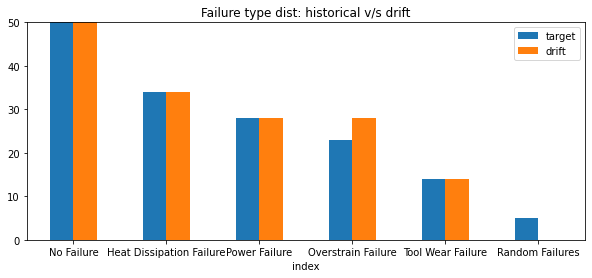

In [15]:
plt.rcParams['figure.figsize'] = (10,4)
d.plot(x='index',
        kind='bar',
        stacked=False,
        title='Failure type dist: historical v/s drift')
plt.ylim([0,50])
plt.xticks(rotation = 0)
plt.show()

In [16]:
X_drift['target'].value_counts()

No Failure                  2896
Heat Dissipation Failure      34
Power Failure                 28
Overstrain Failure            23
Tool Wear Failure             14
Random Failures                5
Name: target, dtype: int64

In [17]:
X_drift['target'] = np.where(X_drift['target'] == 'Random Failures', 'Overstrain Failure', X_drift['target'])
X_drift['target'].value_counts()

No Failure                  2896
Heat Dissipation Failure      34
Overstrain Failure            28
Power Failure                 28
Tool Wear Failure             14
Name: target, dtype: int64

In [18]:
!pip install evidently


# Evidently

**Data drift - test and drift**

In [19]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, ClassificationPerformanceTab
from evidently.pipeline.column_mapping import ColumnMapping

drift_column_mapping = ColumnMapping()
drift_column_mapping.categorical_features = ['type']
drift_column_mapping.numerical_features = ['air_temperature_[k]', 'process_temperature_[k]'
                                          ,'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]' ]

data_drift_report = Dashboard(tabs=[DataDriftTab()])
data_drift_report.calculate(X_test,X_drift,column_mapping = drift_column_mapping)
data_drift_report.show()

In [20]:
data_drift_report.save('data_drift_evidently.html')

**Concept drift - test and drift**

In [21]:
from evidently.tabs import DataDriftTab, CatTargetDriftTab
column_mapping = ColumnMapping()

column_mapping.categorical_features = ['type']
column_mapping.numerical_features = ['air_temperature_[k]', 'process_temperature_[k]'
                                          ,'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]' ]
column_mapping.target = 'target'

concept_drift_report = Dashboard(tabs=[DataDriftTab(),CatTargetDriftTab()])
concept_drift_report.calculate(X_test,X_drift,column_mapping = column_mapping)
concept_drift_report.show()

In [22]:
concept_drift_report.save('concept_drift_evidently.html')

## Alibi Detect

**Data drift (also called co-variate drift)**

In [23]:
from sklearn.model_selection import train_test_split
type_conv = {0:'L',
            1:'M',
            2:'H'}
df['type'] = df['type'].map(type_conv)
X = df.drop(columns = ['failure_type', 'target', 'udi', 'product_id'])
y = df['failure_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2022)

print(f'''Shape of train and test data:
training data:{X_train.shape[0]} obs
testing data :{X_test.shape[0]} obs''')

Shape of train and test data:
training data:7000 obs
testing data :3000 obs


In [24]:
#import alibi
from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector

##### initialize the detector
category_map = {0: None}
categories_per_feature = {f: None for f in list(category_map.keys())}
cd = TabularDrift(X_test.values, p_val=.05, categories_per_feature=categories_per_feature)

In [25]:
dataset = {'X_test': X_test, 'X_drift': X_drift}

out_dfs = pd.DataFrame()
for k, v in dataset.items():
    print(k)
    preds = cd.predict(dataset[k].values)
    
    out_df = pd.DataFrame()
    for f in range(cd.n_features):
        #print(preds)
        stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
        fname = list(v.columns)[f]
        stat_val = preds['data']['distance'][f]
        p_val = preds['data']['p_val'][f]
        #print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
        drift = ''
        if p_val <= 0.05:
            drift = 'yes'
            print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f} **{drift}**')
        else:
            print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
        drift_list = [k, fname, stat, p_val , drift]
        k_df  = pd.DataFrame([drift_list], columns = ['dataset','attr','stat','p-value','drift'])
        #print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
        out_df = out_df.append(k_df)
    out_dfs = out_dfs.append(out_df)
    print(f'\n')

 

X_test
type -- Chi2 0.000 -- p-value 1.000
air_temperature_[k] -- K-S 0.000 -- p-value 1.000
process_temperature_[k] -- K-S 0.000 -- p-value 1.000
rotational_speed_[rpm] -- K-S 0.000 -- p-value 1.000
torque_[nm] -- K-S 0.000 -- p-value 1.000
tool_wear_[min] -- K-S 0.000 -- p-value 1.000


X_drift
type -- Chi2 6000.000 -- p-value 0.000 **yes**
air_temperature_[k] -- K-S 0.000 -- p-value 1.000
process_temperature_[k] -- K-S 0.000 -- p-value 1.000
rotational_speed_[rpm] -- K-S 0.785 -- p-value 0.000 **yes**
torque_[nm] -- K-S 0.000 -- p-value 1.000
tool_wear_[min] -- K-S 0.000 -- p-value 1.000




In [27]:
!pip install lightgbm

**Concept drift**

In [28]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score

In [29]:
print(f'''Failure % of Total = {(1-(9652/10000)):.2f}%''')

Failure % of Total = 0.03%


In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['failure_type'] = le.fit_transform(df['failure_type'])
df['type'] = X['type'].map(enc_dict)

X = df.drop(columns = ['failure_type', 'target', 'udi', 'product_id'])
y = df['failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2022)


In [31]:
classifier = lgb.LGBMClassifier()
classifier.fit(X_train.values,y_train.values)
predictions = classifier.predict(X_test.values)
print(f"Accuracy: {recall_score(y_test,predictions, average ='micro'):.2f}%")

Accuracy: 0.99%


In [32]:
try:
    X_drift = X_drift.drop(['target'], axis = 1)
except:
    pass
y_drift = y_test.copy()
predictions = classifier.predict(X_drift.values)
print(f"Accuracy: {recall_score(y_drift,predictions, average='micro'):.2f}%")

Accuracy: 0.72%


# whylogs

In [33]:
from whylogs import get_or_create_session
session = get_or_create_session()

ModuleNotFoundError: No module named 'whylogs'

In [59]:
with session.logger(dataset_name="X_test") as logger:
    logger.log_dataframe(X_test)

In [60]:
from whylogs.viz import profile_viewer
profile_viewer()

In [61]:
with session.logger(dataset_name="X_drift") as logger:
    logger.log_dataframe(X_drift)

In [62]:
profile_viewer()

In [28]:
import pandas as pd
import os
from whylogs.app import Session
from whylogs.app.writers import WhyLabsWriter

os.environ["WHYLABS_API_KEY"] = "h3HTe5apkV.FZNtbKRKrEEdUw3iKqlNvp6eOdLVkgKMzp8Id0g78PIAeIwNUrKnz"
os.environ["WHYLABS_DEFAULT_ORG_ID"] = "org-k7Zhkc"

# Adding the WhyLabs Writer to utilize WhyLabs platform
writer = WhyLabsWriter("", formats=[])

session = Session(project="demo-project", pipeline="demo-pipeline", writers=[writer])

# Point to your local CSV if you have your own data
#df = pd.read_csv("https://whylabs-public.s3.us-west-2.amazonaws.com/datasets/tour/current.csv")

# Run whylogs on current data and upload to WhyLabs.
# Note: the datasetId is the same as the modelId
# The selected model project "Model_drift  (model-3)" is "model-3"

with session.logger(tags={"datasetId": "model-3"}) as ylog:
    ylog.log_dataframe(X_test)
  

Using API key ID: h3HTe5apkV
Failed to upload org-k7Zhkc/model-3/1643950924599 to https://api.whylabsapp.com with API token ID: h3HTe5apkV
Traceback (most recent call last):
  File "C:\Users\yash.kumar\Anaconda3\lib\site-packages\whylogs\whylabs_client\wrapper.py", line 94, in _upload_whylabs
    result = log_api.log_async(org_id=org_id, dataset_id=dataset_id, log_async_request=request)
  File "C:\Users\yash.kumar\Anaconda3\lib\site-packages\whylabs_client\api_client.py", line 772, in __call__
    return self.callable(self, *args, **kwargs)
  File "C:\Users\yash.kumar\Anaconda3\lib\site-packages\whylabs_client\api\log_api.py", line 276, in __log_async
    return self.call_with_http_info(**kwargs)
  File "C:\Users\yash.kumar\Anaconda3\lib\site-packages\whylabs_client\api_client.py", line 834, in call_with_http_info
    return self.api_client.call_api(
  File "C:\Users\yash.kumar\Anaconda3\lib\site-packages\whylabs_client\api_client.py", line 409, in call_api
    return self.__call_api(r